In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from IPython import display
import time

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [15]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)

Test data shape:  (4, 320, 256, 256)


In [16]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [17]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [18]:
def denoise(guidance, model, K, beta_min = 1e-4, beta_max = 0.02, steps=[1000], output_freq=10, show_intermediate_output=False):
    for i in range(K):
        betas = torch.linspace(beta_min, beta_max, steps[i]).to(device)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        epsilon = torch.randn_like(guidance).to(device)
        x_t = torch.sqrt(alphas_cumprod[steps[i]-1]) * guidance + \
        torch.sqrt(1 - alphas_cumprod[steps[i]-1]) * epsilon
        for t in reversed(range(1, steps[i]+1)):
            assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
            if show_intermediate_output and (t%output_freq == 0 or t == 1):
                plt.imshow(x_t.squeeze().cpu())
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.01)
                
            # Calculate the parameters
            alpha_t_bar = alphas_cumprod[t-1]
            beta_t = betas[t-1]
            alpha_t = alphas[t-1]
            # Predict the noise using the model
            with torch.no_grad():
                epsilon_theta = model(x_t)

            # Make sure the output of the model (the predicted noise) has a single channel
            assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."
            # Calculate the mean of the previous step in the backward process of diffusion model
            mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
            # Add noise for all but the last step (strictly follow the algorithm)
            if t > 1:
                # z = torch.randn_like(x_t).to(device)
                z = torch.randn_like(x_t).to(device)
                x_t = mean + torch.sqrt(beta_t) * z
            else:
                x_t = mean

        guidance = x_t
        #plt.show()
    return x_t

(4, 10, 1024)


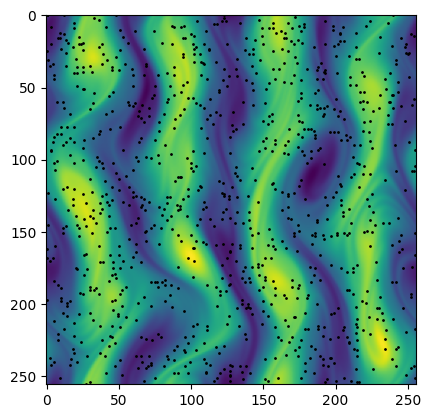

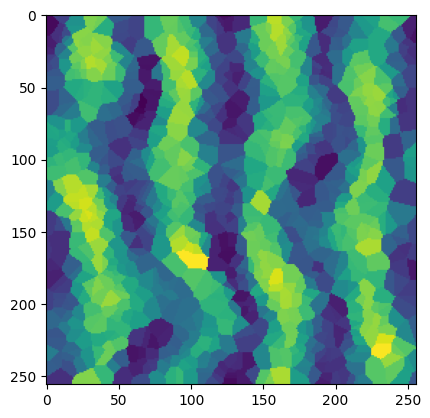

In [19]:
#Randomly choose a fixed percentage of points from the test snapshot
percentage = 1.5625
factor = percentage/100
N = int(256**2 * factor)
test_snapshots = test_data
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshots[:, :10, nx, ny]

#Nearest neighbor interpolation
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
coordinates = np.vstack((nx, ny)).T
#interpolated_sparse_measurement = interpolate.griddata(coordinates, sparse_measurement, (xx,yy), method='nearest').T
sparse_measurement_list = []
print(sparse_measurement.shape)
for i in range(sparse_measurement.shape[0]):
    sl_list = []
    for j in range(sparse_measurement.shape[1]):
        sl_list.append(interpolate.griddata(coordinates, sparse_measurement[i,j], (xx,yy), method='nearest').T)
    sparse_measurement_list.append(sl_list)

interpolated_sparse_measurement = np.array(sparse_measurement_list)

#Visualize location of selected points and interpolated sparse measurements
figure,ax = plt.subplots()
figure2,ax2 = plt.subplots()
ax.imshow(test_snapshots[0,5])
mask = np.zeros((256, 256))
mask[nx, ny] = 1
ax.scatter(xx*mask, yy*mask, s=1, c="black")
ax2.imshow(interpolated_sparse_measurement[0, 5])


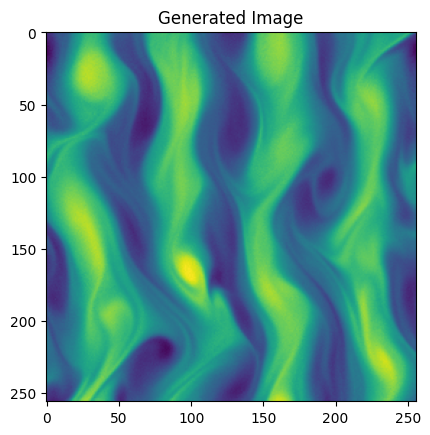

In [26]:

#Generate high fidelity data from sparse mesurements
#interpolated_sparse_measurement = torch.tensor(interpolated_sparse_measurement[3,-1], dtype=torch.float32).unsqueeze(1).to(device)
sparse_measurement = torch.tensor(interpolated_sparse_measurement[0],  dtype=torch.float32).unsqueeze(1).to(device)
K = 1
steps = np.ones((K,), dtype=np.int16) * 100
generated_image = denoise(sparse_measurement, model,steps=steps, K=K, beta_max=0.002, output_freq=10, show_intermediate_output=False).squeeze().detach().cpu().numpy()
plt.imshow(generated_image[5])
plt.title("Generated Image")
plt.savefig("beta_max_0_02_S_400.png", dpi=400)

Input SSIM:  0.4975388741253887
Generated Image SSIM:  0.504010550546556
Generated Image PSNR:  26.174485415097667
Average Relative Error at Sparse Measurement Locations: 168.4429931640625%
354
-0.027864663 -0.086223066


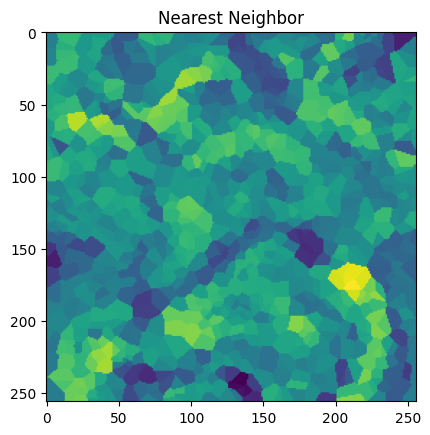

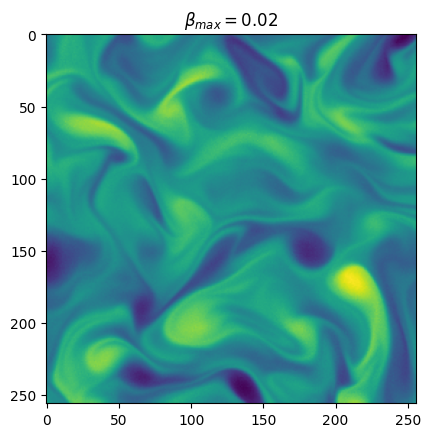

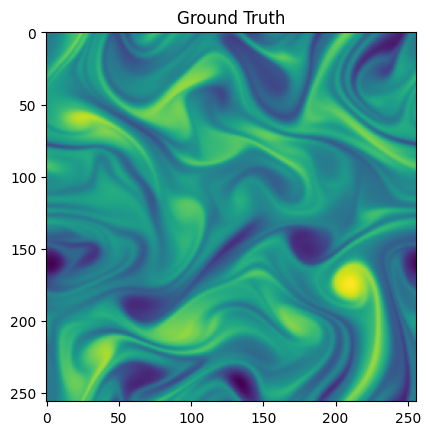

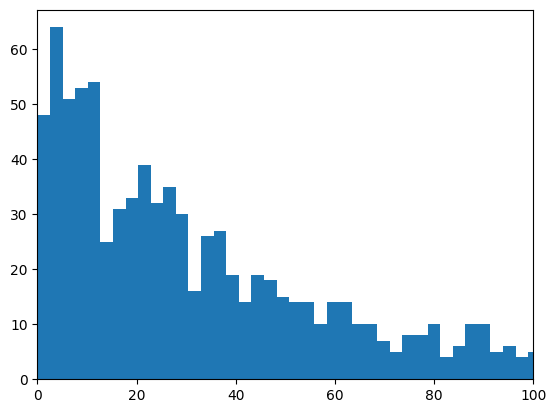

In [75]:
#Plot generated field and ground truth
figure3, ax3  = plt.subplots()
figure4, ax4 = plt.subplots()
figure5, ax5 = plt.subplots()
figure6, ax6 = plt.subplots()

ax3.imshow(sparse_measurement.squeeze().detach().cpu().numpy())
ax3.set_title("Nearest Neighbor")
figure3.savefig("Nearest Neighbor.png", dpi=400)

ax4.imshow(generated_image)
ax4.set_title(r"$\beta_{max}=0.02$")
figure4.savefig("Beta_max_0.02.png", dpi=400)

ax5.imshow(test_snapshot)
ax5.set_title("Ground Truth")
figure5.savefig("Ground_Truth.png", dpi=400)

#Calculate quality metrics
PSNR = peak_signal_noise_ratio(test_snapshot, generated_image, data_range=2.0)
SSIM = structural_similarity(test_snapshot, generated_image, data_range=2.0)
SSIM_Sparse = structural_similarity(test_snapshot, interpolated_sparse_measurement, data_range=2.0)
print("Input SSIM: ", SSIM_Sparse)
print("Generated Image SSIM: ", SSIM)
print("Generated Image PSNR: ", PSNR)


#Compare values at sparse measurement locations
generated_image_sparse_measurements = generated_image[nx, ny]
ground_truth_sparse_measurements = test_snapshot[nx, ny]
sparse_measurement_error = 100*np.abs((generated_image_sparse_measurements - ground_truth_sparse_measurements)/ground_truth_sparse_measurements)
print(f"Average Relative Error at Sparse Measurement Locations: {np.mean(sparse_measurement_error)}%")
ax6.hist(sparse_measurement_error, bins=10000)
ax6.set_xlim([0,100])
print(np.sum(sparse_measurement_error < 20))
print(generated_image_sparse_measurements[24], ground_truth_sparse_measurements[24])




0.05323391 1.0


IndexError: index 1 is out of bounds for axis 0 with size 1

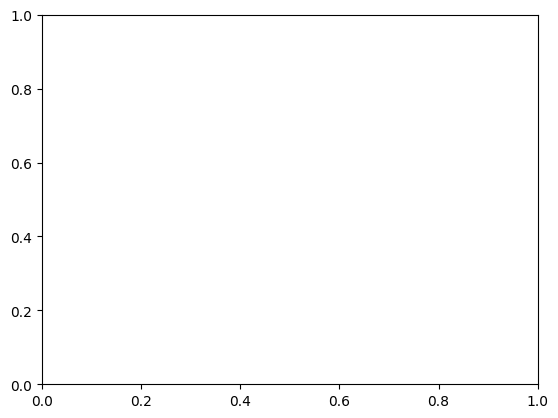

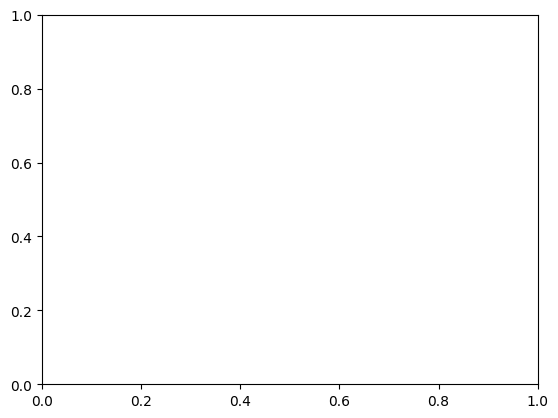

In [29]:
import os
from energy_spectrum import compute_tke_spectrum

#sparse_measurement = torch.tensor(interpolated_sparse_measurement, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
S = [100]
K = [1,2,3,4]
path = "/home/baris/Documents/DDSim/baris-personal/sparse/"

def two_point_corr(field, axis=0):
    number_of_cells = field.shape[axis]
    mean = np.mean(field)
    field_prime = field 
    var = np.mean(field_prime * field_prime)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=axis)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    if axis == 1:
        print(var, f_corr[0])

    return f_corr


def parametric(K,S):
    figure, axis = plt.subplots()
    figure2, axis2 = plt.subplots()
    SSIM_Sparse_List = []
    SSIM_List = []
    MSE_List = []
    two_point_corr_list = []
    energy_spetrum_list = []
    for s in S:
        for k in K:           
            path_K = os.path.join(path, "K_" + str(k))
            path_K_str = path + "K_" + str(k)
            if not os.path.exists(path_K):
                os.makedirs(path_K)
            #plt.imshow(test_snapshot)
            #plt.savefig(path_K_str + "/ground_truth")
#
            #steps = np.ones((k,), dtype=np.int16) * s
            generated_image = denoise(sparse_measurement, model,steps=steps, K=k, beta_max=0.002, output_freq=10).squeeze().detach().cpu().numpy()
            #PSNR = peak_signal_noise_ratio(test_snapshot, generated_image, data_range=2.0)
            #SSIM = structural_similarity(test_snapshot, generated_image, data_range=2.0)
            #SSIM_Sparse = structural_similarity(test_snapshot, interpolated_sparse_measurement, data_range=2.0)
            #MSE = np.mean((test_snapshot - generated_image)**2)

            #print(f"S = {s}")
            #print(f"K = {k}")
            #print(f"Input SSIM: {SSIM_Sparse}")
            #print(f"Generated Image SSIM: {SSIM}")
            #print(f"Generated Image PSNR: {PSNR}")
            #axis2.imshow(generated_image)
            #figure2.savefig(path_K_str + "/S_" + str(s))
            #SSIM_List.append(SSIM)
            #SSIM_Sparse_List.append(SSIM_Sparse_List)
            #MSE_List.append(MSE)
            two_point_corr_list.append(two_point_corr(generated_image, axis=1))
            _,_, spectrum = compute_tke_spectrum(generated_image[5],1,1)
            energy_spetrum_list.append(spectrum)

    #if len(K) == len(SSIM_List):
    #    axis.plot(K, SSIM_List, "-o")
    #    independent_variable = "Number of Timesteps"
    #elif len(S) == len(SSIM_List):
    #    axis.plot(S, SSIM_List, "-o")
    #    independent_variable = "Number of Iterations"


    #axis.set_xlabel(independent_variable)
    #axis.set_ylabel("SSIM")
    #figure.savefig(independent_variable + "_vs_SSIM_2.png", dpi=400)
    return np.array(two_point_corr_list), np.array(energy_spetrum_list)

two_point_corr_array, spectrum_generated_image = parametric(K,S)
figure3, axis3 = plt.subplots()
figure4, axis4 = plt.subplots()
axis4.set_xscale("log")
axis4.set_yscale("log")

nyquist, wave_numbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshots, 1,1)

nyquist = int(nyquist/(2*np.pi))
axis3.plot(two_point_corr_array.T)
test_snapshots = test_data[3]
print(test_snapshots.shape)
two_point_corr_ground_truth = two_point_corr(test_snapshots, axis=1)
axis3.plot(two_point_corr_ground_truth.T, "--")

axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_generated_image.T[:nyquist])
axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_ground_truth.T[:nyquist], "--")


(array([0.03446038, 0.03938348, 0.03938329, 0.04307547, 0.03446038,
        0.04676788, 0.0443062 , 0.06522857, 0.07261329, 0.07015149,
        0.1329186 , 0.21660914, 0.2744523 , 0.2387612 , 0.25352993,
        0.29045246, 0.25722273, 0.24983775, 0.27322157, 0.30152904,
        0.30275977, 0.35937252, 0.46767769, 0.58459712, 0.51567495,
        0.59690442, 0.67197739, 0.79874427, 0.79012726, 0.86028081,
        0.92304586, 0.92674027, 0.94273977, 0.97104424, 1.10273477,
        1.11011649, 1.26272977, 1.39687607, 1.54825931, 1.63317581,
        1.90517581, 2.14515858, 2.23746316, 2.17838823, 2.17716797,
        2.19315696, 2.33345993, 2.14147669, 2.18084968, 2.21038715,
        2.25469335, 2.17347577, 2.06762272, 2.02577798, 2.03808526,
        1.99255791, 1.95316504, 1.72055748, 1.69102814, 1.63440653,
        1.52856394, 1.39318388, 1.18519658, 1.12119304, 1.02273481,
        1.01658606, 0.94027605, 0.93904532, 0.91812295, 0.81966866,
        0.80735744, 0.73843669, 0.77290078, 0.69

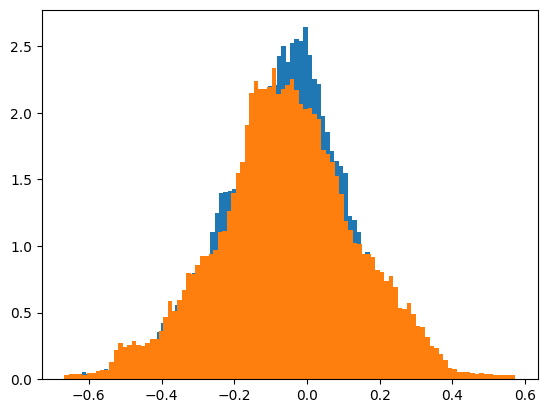

In [98]:
fig2, ax2 = plt.subplots()

ax2.hist(generated_image.flatten(), bins=100, density=True)
ax2.hist(test_snapshot.flatten(), bins=100, density=True)
